# Context-Aware Question Answering with Memory Networks(~100% accuracy)

### In this notebook we will create a memory network using attention mechanism.

 A Memory Network is a type of a neural network architecture which are specifically 
  designed for tasks that require reasoning over long term dependencies.
Memory Network works in multiple hops,each hop allows the model to revisit the memory
  refining the info retrieved at each hop.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tarfile
import re
import keras
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.layers import Dense,Input,Embedding,Reshape,dot,add,Activation,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import get_file

## 1.Getting the data

In [2]:
path=get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar=tarfile.open(path)

In [3]:
challenges={'single_supporting_fact_hindi':
            'tasks_1-20_v1-2/hn-10k/qa1_single-supporting-fact_{}.txt',  
            'two_supporting_fact_english':
            'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'}

## 2.Preprocessing the data

In [4]:
# Tokenization
def tokenize(sent):
    return [x.strip() for x in re.split('\W+?',sent) if x.strip()]    

In [5]:
# The get_stories() will return us the data in the form of triplets-(story,question,answer)
def get_stories(f):
    data=[]
    story=[]    
    for line in f:
        line=line.decode('utf-8').strip()
        nid,line=line.split(' ',1)
        if int(nid)==1:
            story=[]
        if '\t' in line:                         # question<tab>answer<tab>lineno.
            q,a,supporting=line.split('\t')
            q=tokenize(q)
            story_so_far=[[str(i)]+s for i,s in enumerate(story) if s]
            data.append((story_so_far,q,a))
            story.append('')
        else:
            story.append(tokenize(line))
    return data

In [6]:
#The flatten() funcn will recursively flatten a list which will be useful in getting the total vocab size
def should_flatten(el):
    return not isinstance(el,(str,bytes))
def flatten(l):
    for el in l:
        if should_flatten(el):
            yield from flatten(el)
        else:
            yield el 

In [7]:
# Vectorizing and padding the story in the data along the column so that
# all the sentences in the story have same no. of words
def vectorize_stories(data,word2idx,story_maxlen,queries_maxlen):
    inputs,queries,ans=[],[],[]
    for story,querie,answer in data:
        inputs.append([[word2idx[w] for w in s]for s in story])
        queries.append([word2idx[w] for w in querie])
        ans.append(word2idx[answer])
        
    return (
            [pad_sequences(s,maxlen=story_maxlen) for s in inputs],
            pad_sequences(queries,maxlen=queries_maxlen),
            np.array(ans)
    )

In [8]:
#padding along the row so that every story have same no of sentences
def stack_inputs(inputs,story_maxsents,story_maxlen):
    for i,story in enumerate(inputs):
        inputs[i]=np.concatenate([story,
                                 np.zeros((story_maxsents-story.shape[0],story_maxlen),'int')
                                 ]
                                )
    return np.stack(inputs)

In [9]:
def get_data(challenge_type):
    challenge=challenges[challenge_type]
    
    # Extracting train and test stories
    train_stories=get_stories(tar.extractfile(challenge.format('train')))
    test_stories=get_stories(tar.extractfile(challenge.format('test')))
    
    # Adding both train and test stories for vocabulary
    stories=train_stories+test_stories           
   
    story_maxlen=max((len(s) for x,_,_ in stories for s in x)) # Max length of a sentence
    querie_maxlen=max(len(x) for _,x,_ in stories)             # Max length of a question
    story_maxsents=max(len(x) for x,_,_ in stories)            # Max sentences in a story
    
    vocab=sorted(set(flatten(stories)))       # Total Vocabulary
    vocab.insert(0,'<PAD>')                   # Represents Padding during preprocessing 
    vocab_size=len(vocab)                        
    
    word2idx={w:i for i,w in enumerate(vocab)}  # Assigning a number to each word in vocabulary
    
    # Making the story shape uniform 
    input_train,querie_train,answer_train=vectorize_stories(
        train_stories,
        word2idx,
        story_maxlen,
        querie_maxlen
    )
    
    input_test,querie_test,answer_test=vectorize_stories(
        test_stories,
        word2idx,
        story_maxlen,
        querie_maxlen
    )
    
    input_train=stack_inputs(input_train,story_maxsents,story_maxlen)
    input_test=stack_inputs(input_test,story_maxsents,story_maxlen)
    print('input train shape,input test shape',input_train.shape,input_test.shape)
    
    return train_stories,test_stories,\
           input_train,querie_train,answer_train,\
           input_test,querie_test,answer_test,\
           story_maxlen,querie_maxlen,story_maxsents,\
           vocab_size,vocab

# Single Supporting fact Model

In [10]:
train_stories,test_stories,\
input_train,querie_train,answer_train,\
input_test,querie_test,answer_test,\
story_maxlen,querie_maxlen,story_maxsents,\
vocab_size,vocab = get_data('single_supporting_fact_hindi')

input train shape,input test shape (10000, 10, 7) (1000, 10, 7)


## 3. Defining Model Architecture


We will use bag of words(BOW) approach in creating sentence vector , 
the sum operation treats each sentence as a "Bag of Words" , 
disregarding their order of words but retaining their collective meaning.

it will be like:-                  
                                     
 (sentence in normal form) how are you -- vector -->  [ [] , [] , [] ]  -- + -->  [ [] ] (sentence in BOW approach)
 
Individual word vectors of a sentence are summed to form a single sentence vector.

In [11]:
embedding_dim=20

input_story=Input(shape=(story_maxsents,story_maxlen))
embedded_story=Embedding(vocab_size,embedding_dim)(input_story)
print('embedded story shape=',embedded_story.shape)
# Applying BOW approach on story sentences 
embedded_story=Lambda(lambda x : tf.reduce_sum(x,axis=2),output_shape=(story_maxsents,embedding_dim))(embedded_story)
print('embedded story shape after bag of words approach:',embedded_story.shape)

embedded story shape= (None, 10, 7, 20)
embedded story shape after bag of words approach: (None, 10, 20)


In [12]:
input_query=Input(shape=(querie_maxlen,))
embedded_query=Embedding(vocab_size,embedding_dim)(input_query)
print('embedded story shape=',embedded_query.shape)
# Applying BOW approach on query sentence 
embedded_query=Lambda(lambda x:tf.reduce_sum(x,axis=1),output_shape=(embedding_dim,))(embedded_query)
print('embedded query shape after bag of words approach:',embedded_query.shape)

embedded story shape= (None, 5, 20)
embedded query shape after bag of words approach: (None, 20)


 ### Now , we will apply attention mechanism which will help in determining-
> Which sentence in the story should i pay attention to determine the answer to the question.

In [13]:
#To determine the similarity score between question and sentences we will Reshape the query to apply dot.
embedded_query=Reshape((1,embedding_dim))(embedded_query)
print(embedded_query.shape,embedded_story.shape)

(None, 1, 20) (None, 10, 20)


In [14]:
raw_scores=dot([embedded_story,embedded_query],axes=2)
print("raw similarity score shape:",raw_scores.shape)
# To convert the raw similarity score into attention weights we will apply softmax.
# As softmax is applicable on only one axis we will reshape the raw scores 
raw_scores=Reshape((story_maxsents,))(raw_scores)
print('raw similarity score before softmax:',raw_scores.shape)
atten_score=Activation('softmax')(raw_scores)
# In order to find context vector which will contain all the info of the related sentences we will reshape attention weights
atten_score=Reshape((story_maxsents,1))(atten_score)
print('attention score shape:',atten_score.shape,',embedded story shape:',embedded_story.shape)
context_vec=dot([atten_score,embedded_story],1)
print('context vector shape=',context_vec.shape)
context_vec=Reshape((embedding_dim,))(context_vec)
ans=Dense(vocab_size,activation='softmax')(context_vec)

raw similarity score shape: (None, 10, 1)
raw similarity score before softmax: (None, 10)
attention score shape: (None, 10, 1) ,embedded story shape: (None, 10, 20)
context vector shape= (None, 1, 20)


In [15]:
# Final model architecture
model=Model([input_story,input_query],ans)

In [16]:
display(keras.utils.plot_model(model, show_shapes=True, show_dtype=True))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


None

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-2),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [18]:
# Training the model
hist=model.fit([input_train,querie_train],
               answer_train,
               epochs=5,
               batch_size=32,
               validation_data=([input_test,querie_test],answer_test),
              )

Epoch 1/5
313/313 [==============================] - 4s 5ms/step - loss: 0.7445 - accuracy: 0.7354 - val_loss: 0.0661 - val_accuracy: 0.9810
Epoch 2/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0338 - accuracy: 0.9913 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/5
313/313 [==============================] - 2s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/5
313/313 [==============================] - 2s 5ms/step - loss: 8.2204e-04 - accuracy: 1.0000 - val_loss: 6.3290e-04 - val_accuracy: 1.0000
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 4.8753e-04 - accuracy: 1.0000 - val_loss: 4.0005e-04 - val_accuracy: 1.0000


### Plotting the accuracy and loss metrics

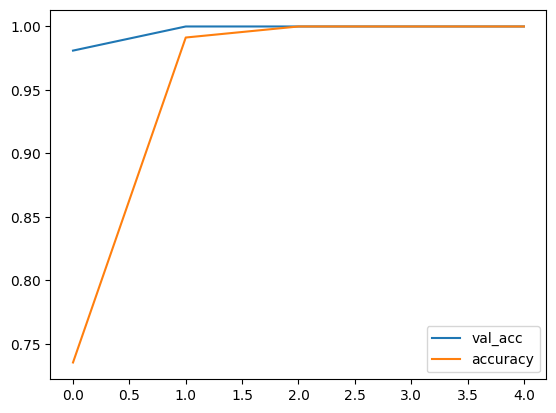

In [19]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

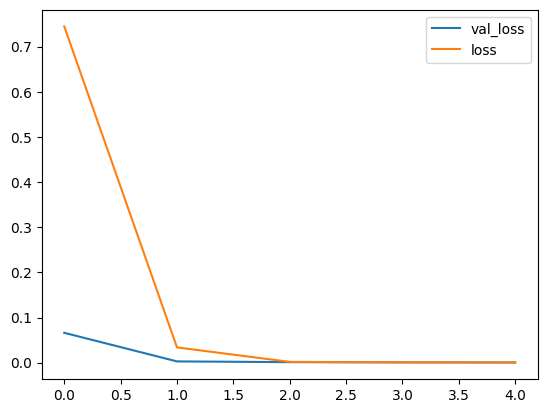

In [20]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

## 4. Model Evaluation
> Lets see how our model used the attention weights to determine the answer

In [21]:
debug_model=Model([input_story,input_query],atten_score)

In [22]:
idx=np.random.choice(len(input_test))  # selecting a random story from data
input_story=input_test[idx:idx+1]
input_query=querie_test[idx:idx+1]
answer=answer_test[idx:idx+1]

w=debug_model.predict([input_story,input_query]).flatten()    #predicting the attention weights

story,query,ans=test_stories[idx]

for i,line in enumerate(story):
    print("{:1.4f}".format(w[i]),"\t"," ".join(line))
    
print('question:',' '.join(query))
print('answer:',ans)

1/1 [==============================] - 0s 104ms/step
0.0000 	 0 Priya daftar mein chali gayi
0.0000 	 1 Badri gusalkhaney mein chala gaya
0.0000 	 3 Sita gusalkhaney mein gayi
0.0000 	 4 Badri bagichey mein gaya
0.0000 	 6 Mohit gusalkhaney gaya
0.0000 	 7 Mohit sayanakaksh gaya
0.0000 	 9 Mohit galiyarey gaya
1.0000 	 10 Badri rasoi ghar mein chala gaya
question: Badri is samay kahan hai
answer: rasoi ghar


 # Two supporting fact Model

In [23]:
train_stories,test_stories,\
input_train,querie_train,answer_train,\
input_test,querie_test,answer_test,\
story_maxlen,querie_maxlen,story_maxsents,\
vocab_size,vocab = get_data('two_supporting_fact_english')

input train shape,input test shape (10000, 88, 7) (1000, 88, 7)


In [24]:
embedding_dim=30

def embed_sum(story,axis):
    x=Embedding(vocab_size,embedding_dim)(story)
    x=Lambda(lambda x:tf.reduce_sum(x,axis))(x)
    return x

In [25]:
input_story=Input(shape=(story_maxsents,story_maxlen))
embedded_story=embed_sum(input_story,2)
print('embedded story shape after bow:',embedded_story.shape)

embedded story shape after bow: (None, 88, 30)


In [26]:
input_query=Input(shape=(querie_maxlen,))
print('input query shape:',input_query.shape)
embedded_query=embed_sum(input_query,1)
print('embedded query shape after bow:',embedded_query.shape)

input query shape: (None, 4)
embedded query shape after bow: (None, 30)


In [27]:
# Creating an additional dense layer to help model capture complex relationship b/w sentences.
dense_layer=Dense(embedding_dim,activation='elu')

In [28]:
def hop(query,story):
    query=Reshape((1,embedding_dim))(query)
    raw_scores=dot([story,query],axes=2)
    raw_scores=Reshape((story_maxsents,))(raw_scores)
    atten_score=Activation('softmax')(raw_scores)
    atten_score=Reshape((story_maxsents,1))(atten_score)
    
    # Recalculating the story embedding in order to incorporate atten_score in story.
    # Adding the new dense_layer and embedded_story2 will help the model to refocus on differnt parts of story
    # so that will increase its understanding of the story
    embedded_story2=embed_sum(input_story,2)
    context_vec=dot([atten_score,embedded_story2],axes=1)
    context_vec=Reshape((embedding_dim,))(context_vec)
    x=dense_layer(context_vec)
    
    return x,embedded_story2,atten_score

### As this require multiple sentences to determine an answer we will pass the answer from first hop to the second hop.
 > We will pass the ans from 1st hop as query to 2nd hop so that model will adjust its focus to new sentences.

In [29]:
ans1,story_embedding1,atten_weight1=hop(embedded_query,embedded_story)
ans2,story_embedding2,atten_weight2=hop(ans1,story_embedding1)

In [30]:
ans=Dense(vocab_size,activation='softmax')(ans2)

In [31]:
# Final model Architecture
model=Model([input_story,input_query],ans)

In [32]:
model.compile(optimizer=RMSprop(learning_rate=5e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [33]:
hist=model.fit([input_train,querie_train],
          answer_train,
          batch_size=32,
          epochs=30,
          validation_data=([input_test,querie_test],answer_test),
         )

Epoch 1/30
313/313 [==============================] - 4s 8ms/step - loss: 1.7736 - accuracy: 0.2445 - val_loss: 1.5464 - val_accuracy: 0.3610
Epoch 2/30
313/313 [==============================] - 2s 7ms/step - loss: 1.0946 - accuracy: 0.5592 - val_loss: 0.7592 - val_accuracy: 0.7270
Epoch 3/30
313/313 [==============================] - 2s 7ms/step - loss: 0.6531 - accuracy: 0.7519 - val_loss: 0.6203 - val_accuracy: 0.7510
Epoch 4/30
313/313 [==============================] - 2s 7ms/step - loss: 0.5216 - accuracy: 0.8041 - val_loss: 0.5645 - val_accuracy: 0.7810
Epoch 5/30
313/313 [==============================] - 2s 7ms/step - loss: 0.4225 - accuracy: 0.8455 - val_loss: 0.5778 - val_accuracy: 0.8020
Epoch 6/30
313/313 [==============================] - 2s 7ms/step - loss: 0.3787 - accuracy: 0.8646 - val_loss: 0.4248 - val_accuracy: 0.8510
Epoch 7/30
313/313 [==============================] - 2s 7ms/step - loss: 0.3265 - accuracy: 0.8822 - val_loss: 0.3781 - val_accuracy: 0.8720
Epoch 

## Plotting the accuracy and loss metrics

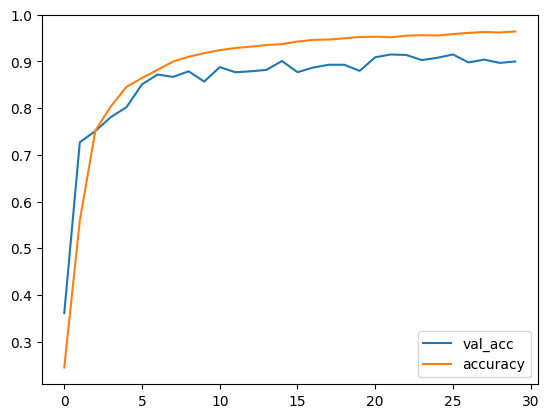

In [34]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

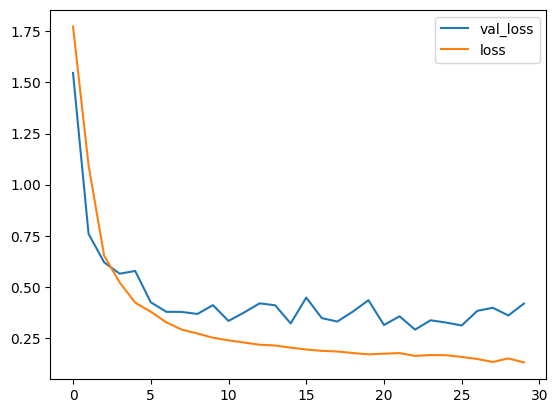

In [35]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

### Lets see how our model adjusted its focus across multiple hop.

In [36]:
debug_model=Model([input_story,input_query],
            [atten_weight1,atten_weight2])

In [38]:
idx=np.random.choice(len(train_stories))
input_story=input_train[idx:idx+1]
input_query=querie_train[idx:idx+1]

w1,w2=debug_model.predict([input_story,input_query],verbose=0)
w1=w1.flatten()
w2=w2.flatten()

story,query,ans=train_stories[idx]

for i,w in enumerate(story):
    print('{:1.5f}'.format(w1[i]),'\t','{:1.5f}'.format(w2[i]),'\t',' '.join(w))

print('question:',' '.join(query))
print('actual answer:',ans)
print('predicted answer:',vocab[np.argmax(model.predict([input_story,input_query],verbose=0))])

0.00000 	 0.00000 	 0 John took the apple there
0.00000 	 0.00000 	 1 Daniel journeyed to the hallway
0.00000 	 0.00000 	 2 Daniel journeyed to the office
0.00000 	 0.00000 	 3 Sandra moved to the bedroom
0.00000 	 0.99561 	 4 John journeyed to the bathroom
0.00000 	 0.00000 	 5 Mary travelled to the kitchen
0.00000 	 0.00002 	 6 Daniel went back to the bathroom
0.00000 	 0.00001 	 7 Mary journeyed to the bedroom
0.00000 	 0.00002 	 8 Daniel went to the hallway
1.00000 	 0.00001 	 9 John discarded the apple there
0.00000 	 0.00433 	 11 John went back to the kitchen
0.00000 	 0.00000 	 12 Sandra moved to the garden
0.00000 	 0.00000 	 14 Daniel went back to the kitchen
0.00000 	 0.00000 	 15 Sandra went to the kitchen
question: Where is the apple
actual answer: bathroom
predicted answer: bathroom
